# Linear Trend Magnitude Global Analysis to check negligibility of linear trend in monthly SWH and WSP data 

Plot figure within jupyter notebook

In [1]:
%matplotlib inline

Use the sys library in order to tell the notebook to look for files within the followinf directory path: 

In [2]:
import sys
sys.path.append('/zdata/home/lcolosi/python_functions/')

Import all libraries and functions

In [15]:
#libraries
import numpy as np #contains the major of functions used for matrix arrays  
import matplotlib.pyplot as plt # matplotlib contains functions for graphics and plot manipulation
from netCDF4 import Dataset, num2date # netCDF4 handles netCDF files
import datetime
import glob
#plotting libraries
import cmocean.cm as cmo
from matplotlib import cm 
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from matplotlib import ticker
import matplotlib
from numpy import pi


#my functions
from unweighted_least_square_fit import least_square_fit 
from char_LSF_curve import character_LSF
from monthly_mean import monthly_average
import cartopy_fig_module as cart

### Ifremer Product 1 SWH 

Set dimensions for data of space and time which depends on the spatial orientation of the data set and the time period which the data is collected from. For the Ifremer data set, we want the following data orientation: 

In [4]:
nt, nlon, nlat = 8400, 360, 133
initial_year = 1993
final_year = 2015
initial_mon = 1
final_mon = 12

Set filename and look at key variables and attributes

In [5]:
#Bia's binned data: 
#filename = '/zdata/downloads/colosi_data_bk/binned_data/ifremer_p1_daily_data/bia_daily_binned_ifremer_data/all_sat_binned_swh_1992-08-23_2016-08-23.nc'
#My binned data: 
filename_swh = '/zdata/downloads/colosi_data_bk/binned_data/ifremer_p1_daily_data/my_daily_binned_ifremer_data/ifremer_swh_daily_binned_data_93_16_bia.nc'
filename_wsp = '/zdata/downloads/colosi_data_bk/binned_data/ifremer_p1_daily_data/my_daily_binned_ifremer_data/ifremer_wsp_daily_binned_data_93_16_bia.nc'

#set nc variable in order to read attributes and obtained data: 
#bia's data:
#nc = Dataset(filename, 'r')
#My data
nc_swh =  Dataset(filename_swh, 'r')
nc_wsp =  Dataset(filename_wsp, 'r')

#print key variables:
print(nc_swh.variables.keys())

#longitude
for at in nc_swh.variables['lon'].ncattrs():
    print("%s : %s" %(at, nc_swh.variables['lon'].getncattr(at)))

#laitude
for at in nc_swh.variables['lat'].ncattrs():
    print("%s : %s" %(at, nc_swh.variables['lat'].getncattr(at)))
    
#time 
for at in nc_swh.variables['time'].ncattrs():
    print("%s : %s" %(at, nc_swh.variables['time'].getncattr(at)))

odict_keys(['time', 'lon', 'lat', 'swh'])
units : degrees east
units : degrees north
units : days since 1900-01-01 00:00:00
calendar : julian


Call Ifremer Product 1 daily binned data from the server

In [6]:
swh = nc_swh.variables['swh'][:]
wsp = nc_wsp.variables['wsp'][:]
lon = nc_swh.variables['lon'][:]
lat = nc_swh.variables['lat'][:]
time_i = num2date(nc_swh.variables['time'][:], nc_swh.variables['time'].units) #convert time directly into datetime format instead of integer value time 

Restrict the latitude dimesnion of the swh and wsp data sets 

In [7]:
swh = swh[:,24:157,:]
wsp = wsp[:,24:157,:]
lat = lat[24:157]
print(lat.shape, swh.shape)

(133,) (8766, 133, 360)


Check to see if swh and wsp are masked arrays

In [8]:
print(swh.shape,time_i.shape)

(8766, 133, 360) (8766,)


Restrict the time series from 1993 to 2015 for swh_cor 

In [9]:
#find initial and final indices: 
#create year vector: 
years = np.array([y.year for y in time_i])

#creat boolean arrays and combine them: 
#ind_92 = years != 1992
ind_16 = years != 2016
#ind_time = ind_92*ind_16
ind_time = ind_16

#use the compress function to find all indices that do not lie in 1992 or 2016 and extract slices of matirx along the time axis from swh
swh_c = np.compress(ind_time, swh, axis = 0)
wsp_c = np.compress(ind_time, wsp, axis = 0)
print(swh_c.shape,wsp_c.shape)

#extract the time steps: 
time_c = time_i[ind_time]


(8400, 133, 360) (8400, 133, 360)


Calculate the monthly averaged swh and wsp from 1993 to 2015

In [10]:
swh_month_data = monthly_average(date_time = time_c, data = swh_c, fill_val = 'mask')
wsp_month_data = monthly_average(date_time = time_c, data = wsp_c, fill_val = 'mask')

Save mean, meadian, standard deviation, and number of observations (will be later used to calculate the standard deviation of the mean) in separate np.array variables. Change each dictionary key from a list to a np.array:

In [11]:
#For swh:
swh_monthly_mean = np.ma.array(swh_month_data['mean'])
swh_monthly_median = np.ma.array(swh_month_data['median'])
swh_monthly_std = np.ma.array(swh_month_data['std'])
swh_monthly_n = np.ma.array(swh_month_data['N'])

#For wsp:
wsp_monthly_mean = np.ma.array(wsp_month_data['mean'])
wsp_monthly_median = np.ma.array(wsp_month_data['median'])
wsp_monthly_std = np.ma.array(wsp_month_data['std'])
wsp_monthly_n = np.ma.array(wsp_month_data['N'])

Create a loop to go through each grid point and compute the unweighted least square fit with linear trend 

In [12]:
#initialize arrays
swh_linear_trend = np.ma.masked_all([nlat, nlon])

for ilat in range(0,nlat):
    for ilon in range(0,nlon):
        
        #call data in monthly mean matrix for swh and wsp: 
        swh_grid = swh_monthly_mean[:,ilat,ilon]
        #swh_grid = swh_c[:,ilat,ilon]
        wsp_grid = wsp_monthly_mean[:,ilat,ilon]
        #wsp_grid = wsp_c[:,ilat,ilon]
        
        #place a conditional statement for swh that will ignore all time series that have less than 200 data points in the time series 
        #find non-masked values: 
        ival_swh = np.ma.nonzero(swh_grid)
        iswh = len(swh_grid[ival_swh])
        print(iswh)
        #place condition:
        if iswh > 46: 
            #compute least square fit:
            swh_hfit, x_swh = least_square_fit(data = swh_grid, trend = 'sinusoidal', parameters = 6, 
                                               period = 12, fill_val = 'mask')
            #save the linear trend coefficient in a 2D array 
            swh_linear_trend[ilat,ilon] = x_swh[1]
            

133
134
134
133
135
139
139
139
140
133
133
128
129
132
130
130
131
131
131
132
132
131
132
132
133
132
133
132
131
131
133
132
132
129
134
137
149
155
157
157
157
153
153
152
146
137
132
126
120
113
108
89
87
77
86
78
78
90
93
93
97
96
94
91
90
90
88
87
86
85
88
89
87
88
89
87
83
81
79
71
63
53
49
53
56
57
68
84
96
118
56
86
96
106
115
139
21
0
71
28
8
0
31
82
0
44
96
55
73
71
79
43
55
37
39
32
19
15
34
52
90
95
103
58
37
27
30
28
37
44
66
126
89
92
101
98
93
61
76
87
87
93
100
100
99
98
96
80
72
53
42
32
33
44
48
52
57
62
53
53
58
68
80
91
100
101
106
109
114
116
117
120
121
122
121
119
128
135
144
156
163
168
168
169
164
162
162
155
151
146
145
148
146
141
138
138
141
138
137
140
141
143
146
145
144
145
143
139
139
140
141
144
145
152
155
160
161
165
166
167
170
171
171
171
168
176
184
188
192
192
200
205
213
219
221
225
227
232
235
243
249
252
252
252
252
254
255
261
261
263
265
264
264
266
267
267
267
266
266
268
266
267
265
267
266
264
263
262
264
267
267
268
268
266
265
259
260


179
183
185
194
199
205
205
218
222
224
231
230
235
236
226
231
245
242
243
246
239
243
248
248
252
251
248
248
247
247
253
253
250
251
246
246
251
244
242
247
238
243
246
245
253
247
249
254
249
242
246
245
239
236
223
211
210
203
202
206
202
202
200
204
211
210
211
226
247
267
271
271
269
267
265
268
269
267
268
267
265
264
262
263
267
268
270
272
273
274
276
274
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
275
276
274
270
272
269
273
269
273
272
273
274
275
275
275
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


275
275
275
275
275
275
275
275
275
275
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
274
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
27
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
276
276
276
276
276
276
276
276
276

276
276
276
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
264
0
273
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
216
0
0
0
0
0
0
0
269
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
272
276
276
273
276
276
273
276
276
276
276
273
276
276
273
276
276
273
276
276
276
276
276
273
276
276
276
276
273
276
276
273
276
276
273
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
68
0
0
0
0
0
0
0
0
0
258
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
273
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
2

276
276
276
276
276
276
276
276
273
276
276
276
276
276
276
276
273
276
276
276
276
276
276
276
276
273
276
276
273
276
276
276
276
273
276
276
276
276
276
276
276
276
273
276
276
273
276
276
276
276
273
276
276
276
276
276
273
276
276
273
276
276
273
276
276
276
276
273
276
276
273
276
276
273
276
276
273
276
276
273
276
273
276
276
273
276
276
273
276
276
273
276
276
273
276
276
272
276
273
276
276
273
276
276
273
276
276
273
276
276
273
203
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
107
272
276
276
273
276
276
273
276
276
273
276
276
276
276
276
276
276
273
276
276
273
276
276
276
276
276
273
276
276
276
276
276
276
276
273
276
276
273
276
276
276
276
276
273
276
276
276
276
276
276
276
276
276
276
275
276
276
275
276
276
271
276
276
276
276
276
276
274
0
0
0
0
0
0
0
0
0
0
0
0
0
222
276
276
276
276
276
276
276
276
276
276
276
276
273
276
276
273
276
276
276
276
276
276
276
276
276
276
274
276
276
273
276
276
273
276
276
276
276
276
276
276
273
276
276
273
276
276
273
276
276
271
276
276


276
276
276
276
273
276
276
276
276
276
276
276
273
276
276
276
276
276
276
276
276
273
276
276
276
276
276
276
276
273
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
272
276
276
276
276
276
273
276
276
276
276
276
273
276
276
273
276
276
276
276
276
276
276
276
276
276
273
276
276
273
276
276
273
276
276
276
276
276
276
276
276
276
276
273
276
276
273
276
276
273
276
276
276
276
276
276
276
276
276
276
273
276
276
273
276
276
273
276
276
276
276
276
276
276
276
276
276
273
276
276
272
276
276
273
276
276
275
276
276
276
276
276
276
276
276
276
276
273
276
276
273
276
276
276
276
276
276
276
276
276
276
276
276
276
273
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
276
276
276
276
276
273
276
262
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
190
269
276
276
276
276
276
273
276
276
276
276
276
276
276
273
276
276
272
276
276
275
276
276
273
276
276
276
276
276
276
276
273
276
276
273
276
276
273
276
276
273


276
276
273
276
276
273
276
272
273
276
273
275
276
273
276
276
273
276
276
273
276
276
265
8
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
273
273
276
273
273
276
273
275
276
273
276
276
272
276
276
276
276
276
273
276
273
272
276
276
276
276
273
276
276
273
276
276
276
276
276
273
276
273
276
276
276
276
276
274
276
276
273
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
275
270
276
276
273
276
274
0
0
0
276
276
276
276
276
276
276
276
273
276
276
276
276
276
271
276
276
276
276
276
276
276
276
276
276
273
276
276
276
276
276
272
276
276
276
276
276
276
276
276
276
276
273
276
276
269
276
276
273
276
276
276
276
276
276
276
276
276
276
273
276
276
273
276
276
273
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
22
270
276
276
276
276
0
0
0
190
271
276
276
272
276
276
276
276
276
276
276
276
276
276
276
276
276
273
276
276
273
276
276
276
276
276
276
276
276
276
276
275
276
276
273
276
276
273
276
276
276
276
276
276
276
276
276
276
2

276
276
276
276
276
273
276
273
273
276
276
272
276
273
276
276
271
276
276
276
276
276
273
276
273
273
276
276
273
276
272
276
276
273
276
276
276
276
276
275
276
273
273
276
274
273
276
273
276
276
264
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
273
273
276
273
273
276
274
276
276
273
276
276
273
276
276
276
276
273
273
276
273
272
276
276
276
276
273
276
276
273
276
276
273
276
271
276
276
273
276
276
276
276
276
273
276
276
273
276
276
271
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
87
0
40
0
0
0
0
0
0
0
74
276
276
276
276
273
276
276
273
276
276
276
276
274
276
276
273
276
276
276
276
276
273
276
276
273
276
276
273
276
276
276
276
271
276
276
276
276
276
273
276
276
273
276
276
273
276
276
276
276
273
276
276
276
276
276
273
276
276
273
276
276
272
276
276
276
276
273
276
276
273
276
276
273
276
276
273
276
276
273
276
257
274
276
272
275
264
268
276
276
274
276
276
273
276
276
271
276
276
276
276
273
262
276
254
276
276
275
256
160
266
276
276
273
276
276

275
276
276
276
276
276
276
276
275
276
276
273
276
276
273
276
276
276
276
276
276
276
276
276
276
270
276
276
273
276
276
272
276
276
275
276
276
274
276
276
276
276
276
276
276
273
276
276
269
276
276
276
276
276
273
276
0
0
0
235
276
276
271
276
275
260
276
95
0
255
276
267
276
19
229
251
264
276
276
266
276
276
253
272
274
269
148
5
243
264
0
0
0
0
259
276
267
276
276
269
276
276
275
276
276
273
276
276
276
276
275
276
276
273
276
276
273
276
276
276
276
276
273
276
276
276
276
275
276
276
273
276
276
273
276
276
273
276
276
273
276
276
276
276
276
276
276
273
276
276
270
276
276
273
276
276
273
276
276
276
276
273
276
276
273
276
276
276
276
276
273
276
276
273
276
276
276
276
273
276
276
272
276
276
276
276
276
273
276
276
273
276
276
276
276
273
276
276
273
276
276
275
276
276
272
276
276
273
276
276
276
276
272
276
276
273
276
276
276
276
276
273
276
276
273
276
276
276
276
273
276
276
271
244
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
27
0
0
0
0
0
0
0
0
0
0
7
109
276
273

276
276
276
276
273
276
276
276
276
276
276
276
273
276
276
271
276
276
276
276
276
272
276
276
276
276
276
276
276
273
276
276
273
276
276
275
276
276
271
276
276
276
276
276
276
276
273
276
276
273
276
276
276
276
276
273
276
276
276
276
276
276
276
272
276
276
273
276
276
276
276
276
273
276
276
276
276
276
276
276
273
276
276
273
276
276
275
276
276
271
276
276
275
276
276
276
276
273
276
276
273
276
276
273
276
276
273
276
276
276
276
110
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
272
276
276
273
276
276
276
276
276
276
276
272
276
276
276
276
276
273
276
276
272
276
276
272
276
276
276
276
273
276
276
275
276
276
271
276
276
272
276
276
273
276
276
276
276
272
276
276
275
276
276
271
276
276
276
276
276
276
276
276
276
151
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
169
0
0
0
0
0
0
0
0
0
0
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276


276
273
276
276
275
276
276
273
207
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
53
152
0
0
0
0
0
270
276
276
275
276
276
273
276
273
273
276
276
273
276
273
276
276
273
276
276
276
276
276
273
276
267
0
0
254
271
276
273
276
276
273
276
276
272
276
276
273
276
273
273
276
276
272
276
242
276
276
271
276
276
94
2
271
276
276
273
273
276
272
273
276
272
276
276
273
276
276
270
246
272
265
276
273
272
276
273
273
276
276
276
276
273
276
276
273
276
276
276
276
273
273
276
273
273
276
276
276
276
273
276
276
273
276
276
275
276
269
276
276
273
273
276
276
276
276
273
276
276
273
276
276
276
276
273
276
276
273
273
276
276
276
276
272
276
276
273
276
276
273
276
273
276
276
273
273
276
276
276
276
276
276
276
273
276
276
272
276
273
276
276
273
273
276
273
276
276
276
276
276
273
276
276
273
276
276
276
276
273
273
276
273
276
276
276
276
276
273
276
276
273
276
276
273
276
273
273
276
273
276
276
276
276
276
273
276
276
27

276
276
268
276
276
275
276
276
276
276
276
276
276
273
276
276
276
276
276
273
276
276
274
276
276
276
276
276
276
276
269
276
276
268
276
276
273
276
276
276
276
276
276
276
276
276
276
274
276
276
273
276
276
270
276
276
269
276
276
276
276
276
276
276
275
276
276
273
276
276
273
276
276
276
276
276
276
276
276
276
276
275
276
276
270
276
276
273
276
276
276
276
276
276
276
276
276
276
276
276
276
273
276
276
267
276
276
276
276
276
276
276
276
122
0
0
0
25
273
276
276
272
276
276
276
276
276
276
276
276
276
276
276
276
276
272
276
276
273
276
276
276
276
276
276
276
276
276
276
276
276
276
273
276
276
272
276
276
272
276
276
276
276
276
276
276
276
276
276
273
276
276
273
276
276
276
276
276
276
276
276
276
276
276
276
276
268
276
276
270
36
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
267
273
276
256
59
0
0
0
0
0
0
0
0
0
222
256
276
275
273
276
272
276
276
273
273
276
273
276
276
276
276
276
273
276
276
0
0
0
0
0
0
0
0

276
276
273
276
276
276
276
276
276
276
276
276
276
273
276
276
276
276
276
273
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
276
276
276
276
276
276
276
276
276
276
276
276
276
273
276
276
273
276
276
276
276
276
276
276
276
276
276
275
276
276
273
276
276
272
276
276
272
276
276
276
276
276
276
276
276
276
246
0
0
0
0
0
0
0
276
276
276
276
276
276
276
275
276
276
271
276
276
273
276
276
272
276
270
274
276
276
276
276
273
276
276
273
276
276
273
276
276
273
276
276
276
276
276
276
276
272
276
276
271
276
276
272
276
276
276
276
276
276
276
276
276
276
273
276
276
272
276
276
273
276
276
276
276
276
276
276
276
276
276
276
276
276
273
276
276
273
240
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
210
276
272
276
0
0
0
0
0
0
0
0
0
0
0
0
2
274
271
239
0
0
250
276
275
273
276
276
276
276
273
276
276
219
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
266
276
273
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
263
184
276
259
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
9
0
0
0
0
0
0
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
255
273
276
273
276
276
0
0
234
273
276
276
273
276
276
275
276
276
273
276
161
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


276
276
276
276
276
276
0
0
0
0
0
0
0
276
269
276
276
272
276
276
272
276
276
276
276
273
276
276
271
276
276
264
276
276
270
218
0
217
276
276
270
255
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
34
0
0
0
0
0
275
276
202
276
276
148
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
272
260
276
276
265
276
276
256
0
0
271
276
276
276
276
275
276
276
273
276
276
276
234
0
272
276
276
273
276
276
276
276
276
276
276
273
276
276
273
276
276
273
276
276
273
276
276
276
276
273
276
276
272
276
276
272
276
276
273
276
276
273
276
273
276
276
273
276
276
273
276
276
273
276
276
273
276
276
272
276
273
276
276
272
276
276
273
276
276
273
276
276
273
276
276
273
276
273
276
276
273
276
276
273
276
276
273
276
276
273
276
276
276
276
273
276
276
273
276
27
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
12
145
276
273
276
276
276
276
276
276
276
276
273
276
276
275
276
276
276
276
273
276
276
2

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
100
275
276
276
276
235
227
240
262
269
273
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
94
247
259
170
257
268
265
262
0
0
0
0
0
0
0
0
0
0
0
0
0
3
0
0
0
0
0
231
243
255
250
260
265
274
276
276
276
276
276
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
267
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
4
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

0
0
0
0
0
3
0
4
0
0
0
0
0
0
0
0
0
0
3
0
0
0
0
0
1
11
16
111
115
112
128
141
148
143
151
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
120
166
190
220
265
272
274
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
273
276
268
273
271
0
22
276
276
276
276
276
276
276
276
276
276
0
208
276
275
114
242
276
276
276
276
276
276
276
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
41
48
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
160
179
184
182
191
204
220
239
245
246
245
254
254
259
266
269
272
274
272
230
0
0
0
0
0
259
273
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
275
273
272
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
2

120
127
136
154
169
169
152
142
9
0
0
1
0
0
0
104
128
123
135
161
198
231
254
259
265
270
273
275
272
0
0
0
0
0
0
0
0
0
0
32
244
275
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
219
0
252
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
255
0
0
0
0
0
0
0
0
148
232
225
215
175
0
0
0
0
0
1
1
0
0
219
227
217
232
235
217
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
10
86
133
149
166
183
194
196
181
116
3
175
181
180
174
174
182
98
0
32
0
109
73
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
17
77
40
20
0
0
0
0
0
1
1
0
0
3
4
0
0
0
0
0
0
0
0
2
0
0
0
3
1
0
1
0
0
0
3
1
99
75
11
73
92
100
106
111
116
109
39
78
59
1
0
61
136
0
0
0
101
130
128
124
124
118

### CCMP version 2 WSP 

Set dimensions for data of space and time which depends on the spatial orientation of the data set and the time period which the data is collected from. For the Ifremer data set, we want the following data orientation: 

In [13]:
nt, nlon, nlat = 8400, 1440, 529
initial_year = 1993
final_year = 2015
initial_mon = 1
final_mon = 12

Set filename and look at key variables and attributes

In [16]:
filenames = sorted(glob.glob('/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/daily_binned_ccmp_v2_data/ccmp_v2_wsp_daily_binned_data_*_high_res.nc'))

#set nc variable in order to read attributes and obtained data: 
nc = Dataset(filenames[0], 'r')

#print key variables:
print(nc.variables.keys())

#longitude
for at in nc.variables['lon'].ncattrs():
    print("%s : %s" %(at, nc.variables['lon'].getncattr(at)))

#laitude
for at in nc.variables['lat'].ncattrs():
    print("%s : %s" %(at, nc.variables['lat'].getncattr(at)))
    
#time 
for at in nc.variables['time'].ncattrs():
    print("%s : %s" %(at, nc.variables['time'].getncattr(at)))
    

odict_keys(['time', 'lon', 'lat', 'wsp'])
units : degrees east
units : degrees north
units : days since 1900-01-01 00:00:00
calendar : julian


Call each data set and append the data from one year onto the end of the previous year 

In [17]:
#initialize 3D array and counters/counter array
wsp_array = np.ma.masked_all([nt, nlat, nlon])
time_array = []
i = 0
yc = 0
year_c = np.array([365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365, 366, 365, 365, 365])

#restrict filename from 1993 to 2015: 
filenames = filenames[0:23]

#loop through each filename to call data: 
for f in filenames: 
    
    #set nc variable in order to read attributes and obtained data: 
    nc_wnd = Dataset(f, 'r')
    #call wind speed data
    wsp = nc_wnd.variables['wsp'][:]
    time_i = num2date(nc_wnd.variables['time'][:], nc_wnd.variables['time'].units)
    #place the wsp and time data into the 3D arrays
    wsp_array[i:i+year_c[yc],:,:] = wsp
    time_array.append([time_i])
    #year counters: 
    i +=year_c[yc]
    yc += 1
    print(f)
    

/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/daily_binned_ccmp_v2_data/ccmp_v2_wsp_daily_binned_data_1993_high_res.nc
/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/daily_binned_ccmp_v2_data/ccmp_v2_wsp_daily_binned_data_1994_high_res.nc
/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/daily_binned_ccmp_v2_data/ccmp_v2_wsp_daily_binned_data_1995_high_res.nc
/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/daily_binned_ccmp_v2_data/ccmp_v2_wsp_daily_binned_data_1996_high_res.nc
/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/daily_binned_ccmp_v2_data/ccmp_v2_wsp_daily_binned_data_1997_high_res.nc
/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/daily_binned_ccmp_v2_data/ccmp_v2_wsp_daily_binned_data_1998_high_res.nc
/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/daily_binned_ccmp_v2_data/ccmp_v2_wsp_daily_binned_data_1999_high_res.nc
/zdata/downloads/colosi_data_bk/binned_data/ccmpv2_wind_data/d

Check to see if swh and wsp are masked arrays

In [18]:
print(np.ma.is_masked(wsp_array),np.ma.is_masked(wsp_array[8390,:,:])) #np.ma.is_masked(x) determines whether input has masked values

False False


Change the time list from lists of numpy masked arrays to a 1D array 

In [19]:
time_c = np.hstack(time_array)[0]

Deresolve each of the wsp 3D array such that the resolution of the figure matches that of Ifremer data

In [20]:
#import running mean library:
from running_mean import running_mean 

#reset nlon and nlat to i degree resolution: 
nlon_c = 360
nlat_c = 133

#initialize 3D array: 
wsp_array_dr = np.ma.masked_all([nt,nlat_c, nlon_c])

#loop through each of the matrices in the 3D array in order to deresolve each matrix one at a time:
for itime in range(0,nt,1):
    
    #call data from the 3D array 
    wsp_array_d  = wsp_array[itime,:,:]
    #preform the deresolution via convolution 
    wsp_dr = running_mean(data = wsp_array_d, k_dim = [4, 4], task = 'deresolve', fill_val = 'none')
    #Save running mean wsp into 3D array: 
    wsp_array_dr[itime,:,:] = wsp_dr
    
print(wsp_array_dr.shape, np.ma.is_masked(wsp_array_dr))

(8400, 133, 360) False


Calculate the monthly averaged swh and wsp from 1993 to 2016

In [21]:
wsp_month_data = monthly_average(date_time = time_c, data = wsp_array_dr, fill_val = 'mask')

Save mean, meadian, standard deviation, and number of observations (will be later used to calculate the standard deviation of the mean) in separate np.array variables. Change each dictionary key from a list to a np.array:

In [22]:
#For wsp:
wsp_monthly_mean = np.ma.array(wsp_month_data['mean'])
wsp_monthly_median = np.ma.array(wsp_month_data['median'])
wsp_monthly_std = np.ma.array(wsp_month_data['std'])
wsp_monthly_n = np.ma.array(wsp_month_data['N'])

Create a loop to go through each grid point and compute the unweighted least square fit and the characteristics of the fit (e.g. residual, amplitude, phase constant, and coefficient of determination) 

In [30]:
#initialize arrays
wsp_linear_trend = np.ma.masked_all([nlat_c, nlon_c])

for ilat in range(0,nlat_c):
    for ilon in range(0,nlon_c):
        
        #call data in monthly mean matrix for swh and wsp:
        wsp_grid = wsp_monthly_mean[:,ilat,ilon]
            
        #place a conditional statement for swh that will ignore all time series that have less than 200 data points in the time series 
        #find non-nan values: 
        ival_wsp = np.ma.nonzero(wsp_grid)
        iwsp = len(wsp_grid[ival_wsp])
        print(iwsp)
        #plcae condition:
        if iwsp > 46:    
            #compute least square fit:
            wsp_hfit, x_wsp = least_square_fit(data = wsp_grid, trend = 'sinusoidal', parameters = 6, 
                                               period = 12, fill_val = 'mask')
            #save the linear trend coefficient in a 2D array 
            wsp_linear_trend[ilat,ilon] = x_wsp[1]
            

276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276
276


Convert from units of m/month and m/s/month to cm/yr and cm/s/yr

In [69]:
swh_linear_trend_c = np.multiply(np.multiply(swh_linear_trend,(100)),(12))
wsp_linear_trend_c = np.multiply(np.multiply(wsp_linear_trend,(100)),(12))

Plot the linear trend coefficient in order to obtain a sense of the magnitude of the linear trend 

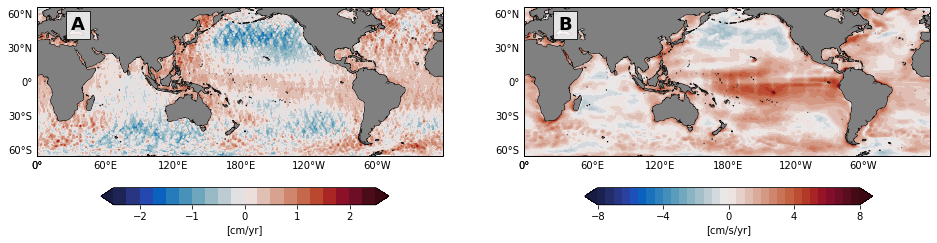

In [70]:
projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(1, 2, figsize=(16,12),
                        subplot_kw={'projection': projection})
ax1, ax2 = axes.flatten()

############## Subplot 1  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-2.5, 2.6, 0.25)
cs1 = ax1.contourf(lon, lat, swh_linear_trend_c, levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color = 'black')
cax1 = plt.axes([.18, .36, 0.25, 0.02])
cart.set_cbar(cs1, cax1, fig, orientation='horizontal', cbar_label ='[cm/yr]', nbins = 5, fontsize = 10, cbar_ticks=[], task='regular')
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-8.0, 8.5, 0.5)
cs2 = ax2.contourf(lon, lat, wsp_linear_trend_c, levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False, fontsize=10, color = 'black')
cax2 = plt.axes([.60, .36, 0.25, 0.02])
cart.set_cbar(cs2, cax2, fig, orientation='horizontal', cbar_label ='[cm/s/yr]', nbins = 5, fontsize = 10, cbar_ticks=[], task='regular')
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/lsf_figs/ccmp2_ifremer_linear_trend_magnitude', bbox_inches = 'tight', dpi=300)


In [71]:
swh_global_mean_linear_trend = np.mean(swh_linear_trend_c)
wsp_global_mean_linear_trend = np.mean(wsp_linear_trend_c)

In [72]:
print('SWH Global Mean Linear Trend')
print(swh_global_mean_linear_trend)
print('WSP Global Mean Linear Trend')
print(wsp_global_mean_linear_trend)

SWH Global Mean Linear Trend
-0.03031183484811933
WSP Global Mean Linear Trend
0.703802729995818
